In [1]:
# Specify location of folder containing datasets
datasets_location = r'C:\datasets'

# Specify file name, message name, and class name for each dataset
datasets = ["IMDB Dataset", "Spam_SMS", "fake_job_postings"]
data_message = ["review", "Message", "description"]
data_class = ["sentiment", "Class", "fraudulent"]

# Specify batch size per dataset
batch_size = [64, 32, 64]

In [2]:
import pandas as pd

# Assign csv data
data = [None] * len(datasets)

# Read in data from csv datasets
for i, file in enumerate(datasets):
    data[i] = pd.read_csv(datasets_location + '\\' + file + ".csv", usecols = [data_message[i], data_class[i]])

In [3]:
from sklearn import preprocessing

# Assign label encoder
label_encoder = [None] * len(datasets)

# Create encoder for data labels
for i, dataset in enumerate(data):
    label_encoder[i] = preprocessing.LabelEncoder()
    label_encoder[i].fit(data[i][data_class[i]])

In [4]:
# Assign simplified csv data
data_simplified = [None] * len(datasets)


# Create simplified datafrfame with int class
for i, file in enumerate(datasets):
    data_simplified[i] = pd.DataFrame()
    data_simplified[i]['label'] = label_encoder[i].transform(data[i][data_class[i]].values.astype(str))
    data_simplified[i]['text'] = data[i][data_message[i]].values.astype(str)

In [5]:
# Assign csv datasets
csv_train_ds = [None] * len(datasets)
csv_test_ds = [None] * len(datasets)

# Constants
TRAIN_SIZE = 0.7

# Split data into train and test
for i, dataset in enumerate(data_simplified):
    csv_train_ds[i] = data_simplified[i].sample(frac=TRAIN_SIZE, random_state=0)
    csv_test_ds[i] = data_simplified[i].loc[~data[i].index.isin(csv_train_ds[i].index)]

In [6]:
import tensorflow as tf

# Assign tensor datasets
train_ds = [None] * len(datasets)
test_ds = [None] * len(datasets)

# Create tensor dataset from adjusted csv data
for i, _ in enumerate(datasets):
    train_ds[i] = tf.data.Dataset.from_tensor_slices((csv_train_ds[i]['text'], csv_train_ds[i]['label']))
    test_ds[i] = tf.data.Dataset.from_tensor_slices((csv_test_ds[i]['text'], csv_test_ds[i]['label']))

In [7]:
# Constants
BUFFER_SIZE = 10000

# Shuffle and batch datasets
for i, _ in enumerate(datasets):
    train_ds[i] = train_ds[i].shuffle(BUFFER_SIZE).batch(batch_size[i]).prefetch(tf.data.AUTOTUNE)
    test_ds[i] = test_ds[i].batch(batch_size[i]).prefetch(tf.data.AUTOTUNE)

In [8]:
import re
import string

# Set vectorization standardization -- Sets input to lowercase and strips HTML and punctuation
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

In [9]:
from tensorflow.keras import layers

# Assign text encoder
text_encoder = [None] * len(datasets)

# Constants
VOCAB_SIZE = 1000

# Prepare text encoder -- Fed custom_standardization to standardize input
for i, dataset in enumerate(train_ds):
    text_encoder[i] = layers.TextVectorization(max_tokens=VOCAB_SIZE, standardize=custom_standardization)
    text_encoder[i].adapt(train_ds[i].map(lambda text, label: text))

In [10]:
# Assign model list
model = [None] * len(datasets)

# Create models -- Embedding learns words, Bidirectional LSMT forms gates, Dense conosolidates an output, Dropout decreases overfitting
for i, dataset in enumerate(train_ds):
    model[i] = tf.keras.Sequential([
        text_encoder[i],
        layers.Embedding(
            input_dim=len(text_encoder[i].get_vocabulary()),
            output_dim=64,
            mask_zero=True),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1)
    ])

In [11]:
# Compile models -- Adam with low learning rate ideal for text classification
for i, _ in enumerate(datasets):
    model[i].compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(1e-4),
        metrics=['accuracy'])

In [12]:
# Assign history
history = [None] * len(datasets)

# Constants
EPOCHS = 10
VALIDATION_STEPS = 30

# Train models on training data, test data as validation
for i, ds in enumerate(train_ds):
    # Training
    history[i] = model[i].fit(
        ds,
        epochs=EPOCHS,
        validation_data=test_ds[i],
        validation_steps=VALIDATION_STEPS)

Epoch 1/10
547/547 [==============================] - 650s 1s/step - loss: 0.6234 - accuracy: 0.5830 - val_loss: 0.4569 - val_accuracy: 0.7849
Epoch 2/10
547/547 [==============================] - 532s 973ms/step - loss: 0.4036 - accuracy: 0.8212 - val_loss: 0.3607 - val_accuracy: 0.8500
Epoch 3/10
547/547 [==============================] - 537s 982ms/step - loss: 0.3390 - accuracy: 0.8568 - val_loss: 0.3294 - val_accuracy: 0.8573
Epoch 4/10
547/547 [==============================] - 560s 1s/step - loss: 0.3169 - accuracy: 0.8683 - val_loss: 0.3300 - val_accuracy: 0.8625
Epoch 5/10
547/547 [==============================] - 561s 1s/step - loss: 0.3065 - accuracy: 0.8709 - val_loss: 0.3174 - val_accuracy: 0.8635
Epoch 6/10
547/547 [==============================] - 557s 1s/step - loss: 0.3024 - accuracy: 0.8731 - val_loss: 0.3153 - val_accuracy: 0.8651
Epoch 7/10
547/547 [==============================] - 557s 1s/step - loss: 0.2988 - accuracy: 0.8761 - val_loss: 0.3146 - val_accuracy: 

In [13]:
from tensorflow.keras import losses

# Test models and print accuracy and loss
for i, file in enumerate(datasets):
    # Testing
    loss, accuracy = model[i].evaluate(test_ds[i])
    print("Loss on \'" + file + ".csv\': ", loss)
    print("Accuracy on \'" + file + ".csv\': ", accuracy)

235/235 [==============================] - 71s 300ms/step - loss: 0.3058 - accuracy: 0.8616
Loss on 'IMDB Dataset.csv':  0.30582955479621887
Accuracy on 'IMDB Dataset.csv':  0.8615999817848206
53/53 [==============================] - 1s 18ms/step - loss: 0.0870 - accuracy: 0.9809
Loss on 'Spam_SMS.csv':  0.08701226860284805
Accuracy on 'Spam_SMS.csv':  0.980861246585846
84/84 [==============================] - 18s 219ms/step - loss: 0.1184 - accuracy: 0.9672
Loss on 'fake_job_postings.csv':  0.11839175224304199
Accuracy on 'fake_job_postings.csv':  0.9671886563301086


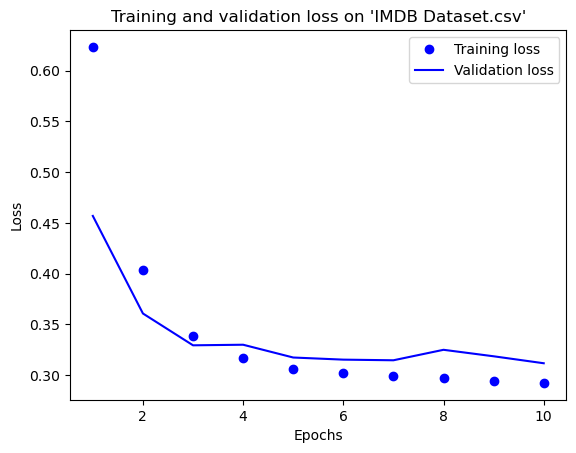

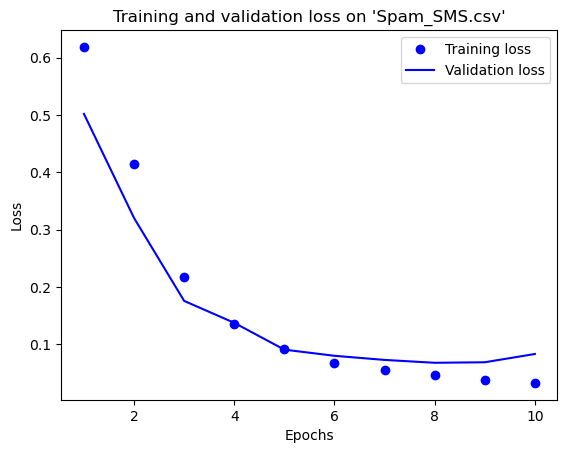

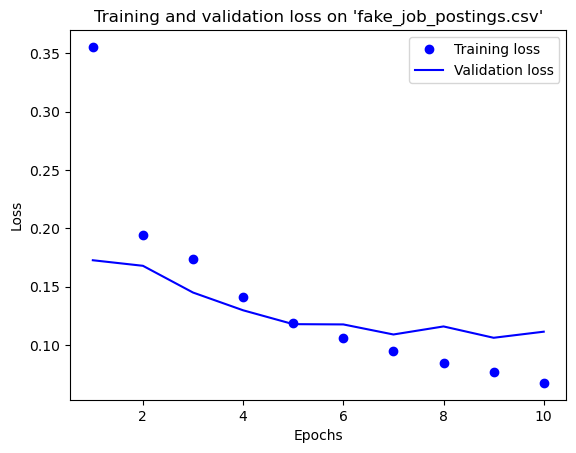

In [18]:
import matplotlib.pyplot as plt

# Plot the loss of the model at each epoch -- Training is dot, validation is line
plot_epochs = range(1, len(history[i].history['loss']) + 1)
for i, file in enumerate(datasets):
    plt.plot(plot_epochs, history[i].history['loss'], 'bo', label='Training loss')
    plt.plot(plot_epochs, history[i].history['val_loss'], 'b', label='Validation loss')
    plt.title("Training and validation loss on \'" + file + ".csv\'")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.show()

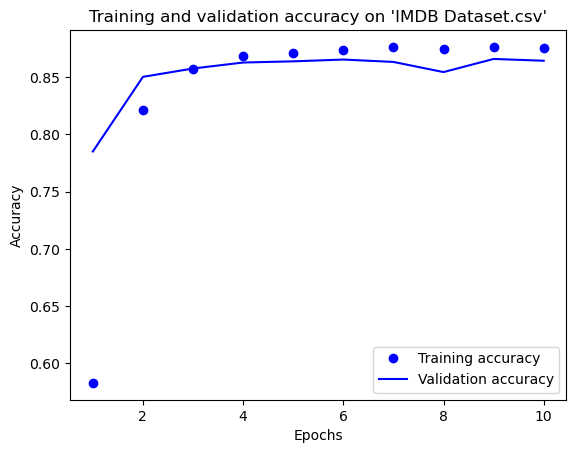

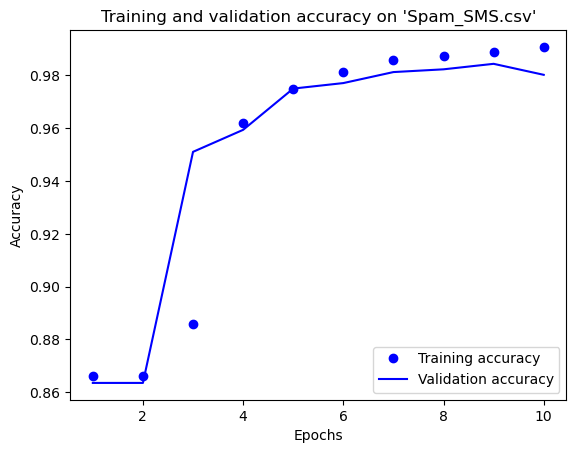

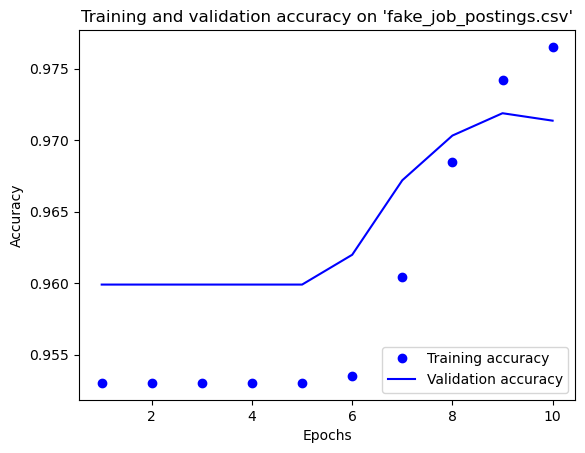

In [21]:
# Assign plots for loss by epoch
acc_plot = [None] * len(datasets)

# Plot the accuracy of the model at each epoch -- Training is dot, validation is line
for i, file in enumerate(datasets):
    plt.plot(plot_epochs, history[i].history['accuracy'], 'bo', label='Training accuracy')
    plt.plot(plot_epochs, history[i].history['val_accuracy'], 'b', label='Validation accuracy')
    plt.title("Training and validation accuracy on \'" + file + ".csv\'")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    plt.show()